# Estimating Price Elasticity of Orange Juice Demand

### Summary of Contents:
1. [Data](#data)
2. [A Gentle Start: Naive ML](#naive)
3. [Parametric Heterogeneity: Double Machine Learning](#dml)
4. [Nonparametric Heterogeneity: Orthogonal Random Forest](#orf)

**Important:** This notebook is an end-to-end solution for this problem. If you are looking for notebook with some room for experimentation, look for the same file name without the "Complete" suffix.

# Data <a class="anchor" id="data"></a>

We use Dominick’s dataset, [a popular historical dataset](https://www.chicagobooth.edu/research/kilts/datasets/dominicks) of store-level orange juice prices and sales provided by University of Chicago Booth School of Business. 

<img src="https://upload.wikimedia.org/wikipedia/commons/f/fd/Orange_juice_1.jpg" width=250px/>

The dataset has ~29,000 observations and includes the store level, weekly prices and sales of 3 different brands of orange juice over 7 years in Chicago area. The dataset also contains 17 continuous and categorical variables that encode store-level customer information such as the age, log income, education level, etc, as well as brand information. We define the following variables:

* Y: Orange Juice sales (log)
* T: Price (log)
* X: Income (feature of heterogeneity)
* W: Store-level features (education, age, etc.)
* $\theta(X)$: Effect of price on sales (Orange juice elasticity)

The goal is to learn the elasticity of orange juice as a function of income in the presence of high-dimensional controls. Thus, we model the world as follows:
$$
\begin{align}
Y & = \theta(X) \cdot T + f(W) + \epsilon\\
T &= g(W) + \eta
\end{align}
$$
where $\epsilon, \eta$ are uncorrelated error terms.

In [1]:
# Helper imports
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import urllib.request 
from itertools import product
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LassoCV, LinearRegression, \
                                 MultiTaskElasticNet, MultiTaskElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import statsmodels.api as sm

# EconML imports
from econml.bootstrap import BootstrapEstimator
from econml.dml import DMLCateEstimator, SparseLinearDMLCateEstimator
from econml.utilities import cross_product

from xgboost import XGBRegressor

%matplotlib inline

import econml
from econml.dml import DMLCateEstimator, LinearDMLCateEstimator,SparseLinearDMLCateEstimator  

from econml.dml import ForestDMLCateEstimator


In [2]:
# Import the data
file_name = "oj_large.csv"

if not os.path.isfile(file_name):
    print("Downloading file (this might take a few seconds)...")
    urllib.request.urlretrieve("https://msalicedatapublic.blob.core.windows.net/datasets/OrangeJuice/oj_large.csv", file_name)
oj_data = pd.read_csv(file_name)

## Data Exploration

In [3]:
oj_data.head()

,store,brand,week,logmove,feat,price,AGE60,EDUC,ETHNIC,INCOME,HHLARGE,WORKWOM,HVAL150,SSTRDIST,SSTRVOL,CPDIST5,CPWVOL5
0,2,tropicana,40,9.018695,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
1,2,tropicana,46,8.723231,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
2,2,tropicana,47,8.253228,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
3,2,tropicana,48,8.987197,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
4,2,tropicana,50,9.093357,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927


In [4]:
oj_data.shape

(28947, 17)

Text(0.5, 1.0, 'Demand vs price of OJ for different brands')

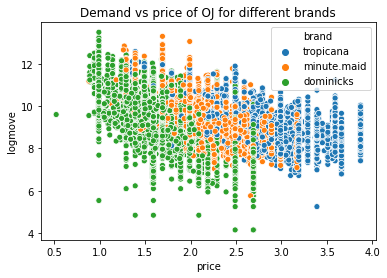

In [5]:
sns.scatterplot(x="price", y="logmove", hue="brand", data=oj_data)
plt.title("Demand vs price of OJ for different brands")

## Data Preprocessing

In [6]:
def process_data(data):
    # Prepare data
    Y = data['logmove'].values
    T = np.log(data["price"]).values
    scaler = StandardScaler()
    W1 = scaler.fit_transform(data[[c for c in data.columns if c not in ['price', 'logmove', 'brand', 'week', 'store','INCOME']]].values)
    W2 = pd.get_dummies(data['brand'], drop_first=True).values
    W = np.concatenate([W1, W2], axis=1)
    X = data[['INCOME']].values
    return Y, T, W, X

Y, T, W, X = process_data(oj_data)

In [7]:
X

array([[10.55320518],
       [10.55320518],
       [10.55320518],
       ...,
       [10.96648993],
       [10.96648993],
       [10.96648993]])

In [12]:
## Generate test data
min_income = 10.0 
max_income = 11.1
# X_test = X_test.reshape(-1, 1)
delta = (max_income - min_income) / 100
X_test = np.arange(min_income, max_income + delta - 0.001, delta).reshape(-1, 1)

## Visualization

Text(0.5, 0, 'Kết cục Y')

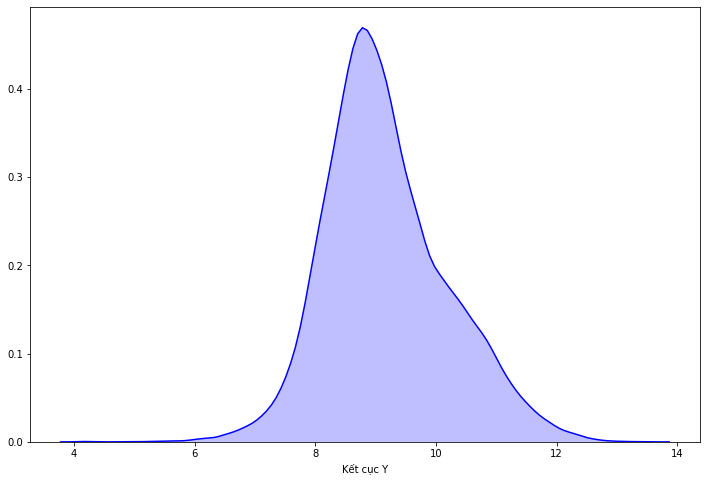

In [13]:
plt.figure(figsize=(12,8))

sns.kdeplot(Y.reshape(Y.shape[0]), shade = True, color = "blue")
plt.xlabel('Kết cục Y')

# Causal effect

## Kha Nhi

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.0min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.4s finished


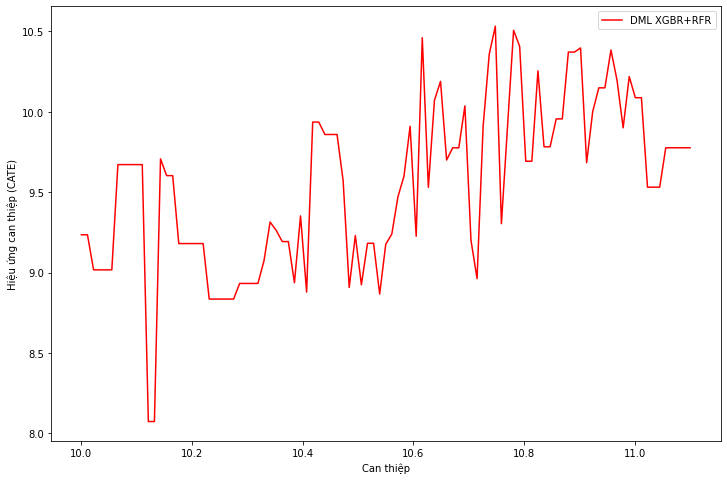

In [25]:
xgb = XGBRegressor(max_depth = 5, learning_rate=0.01, 
                   n_estimators = 50, 
                   verbosity = 0, 
                   booster='gbtree', n_jobs = -1)

est = ForestDMLCateEstimator(model_y=xgb,
                              model_t=xgb,
                              discrete_treatment=False,
                              n_estimators=100,
                              subsample_fr=0.8,
                              min_samples_leaf=10,
                              min_impurity_decrease=0.001,
                              verbose=0,
                              min_weight_fraction_leaf=.01)

est.fit(Y, T, X, W, inference = 'bootstrap')

te_pred = est.effect(X_test)
lb, ub = est.effect_interval(X_test, alpha=0.01)
# te_pred_interval = boot_est.effect_interval(X_test, lower=1, upper=99)
# Performance Visualization
plt.figure(figsize=(12,8))
plt.plot(X_test, te_pred, 'r-', label='DML XGBR+RFR')
plt.ylabel('Hiệu ứng can thiệp (CATE)')
plt.xlabel('Can thiệp')
plt.legend()
plt.show()

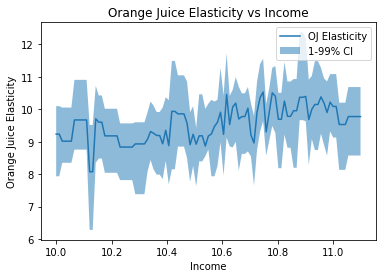

In [28]:
# Plot Orange Juice elasticity as a function of income
plt.plot(X_test.flatten(), te_pred, label="OJ Elasticity")
plt.fill_between(X_test.flatten(), lb , ub, alpha=.5, label="1-99% CI")
plt.xlabel(r'Income')
plt.ylabel('Orange Juice Elasticity')
plt.title("Orange Juice Elasticity vs Income")
plt.legend()
plt.show()

## Github 

/home/dtd/.conda/envs/phd_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/dtd/.conda/envs/phd_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/dtd/.conda/envs/phd_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/dtd/.conda/envs/phd_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explici

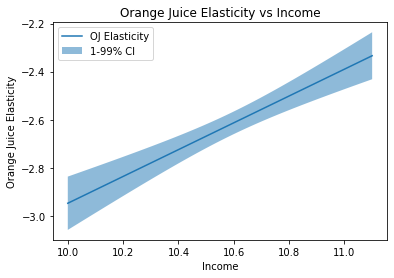

In [34]:
from econml.dml import LinearDMLCateEstimator
from sklearn.linear_model import LassoCV
from econml.inference import BootstrapInference

est = LinearDMLCateEstimator(model_y=LassoCV(), model_t=LassoCV())
### Estimate with OLS confidence intervals
est.fit(Y, T, X, W, inference='statsmodels') # W -> high-dimensional confounders, X -> features
te_pred = est.effect(X_test)
lb, ub = est.effect_interval(X_test, alpha=0.05) # OLS confidence intervals

# Plot Orange Juice elasticity as a function of income
plt.plot(X_test.flatten(), te_pred, label="OJ Elasticity")
plt.fill_between(X_test.flatten(), lb , ub, alpha=.5, label="1-99% CI")
plt.xlabel(r'Income')
plt.ylabel('Orange Juice Elasticity')
plt.title("Orange Juice Elasticity vs Income")
plt.legend()
plt.show()




In [32]:
from econml.dml import ForestDMLCateEstimator
from sklearn.ensemble import GradientBoostingRegressor

est = ForestDMLCateEstimator(model_y=GradientBoostingRegressor(), model_t=GradientBoostingRegressor())
est.fit(Y, T, X, W, inference='blb') 
treatment_effects = est.effect(X_test)
# Confidence intervals via Bootstrap-of-Little-Bags for forests
lb, ub = est.effect_interval(X_test, alpha=0.05)

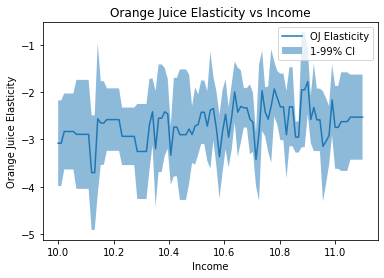

In [33]:
# Plot Orange Juice elasticity as a function of income
plt.plot(X_test.flatten(), treatment_effects, label="OJ Elasticity")
plt.fill_between(X_test.flatten(), lb , ub, alpha=.5, label="1-99% CI")
plt.xlabel(r'Income')
plt.ylabel('Orange Juice Elasticity')
plt.title("Orange Juice Elasticity vs Income")
plt.legend()
plt.show()

## Meta-Learners